# AxCaliber

To estimate the axon diameter distribution itself, CHARMED was adapted to a method called AxCaliber~\citep{assaf2008axcaliber}.
In AxCaliber, the diffusion signal must be measured exactly perpendicular to the axon direction for different gradient strengths and diffusion times.
The signal representation in AxCaliber is given as


\begin{equation}\label{eq:axcaliber}
E_{\textrm{AxCaliber}}= \underbrace{(1-f_r)\overbrace{E_h(\lambda_{\textrm{h}})}^{\textrm{Ball}}}_{\textrm{Extra-Axonal}} + \underbrace{f_r \overbrace{\Gamma(\alpha,\beta)}^{\textrm{Gamma Distribution}}*_{\mathbb{R}}\overbrace{E_r(\cdot|D_\perp)}^{\textrm{Cylinder}}}_{\textrm{Intra-Axonal}}
\end{equation}

where the cylinder was initially represented using the Callaghan model, but was later replaced with the more general Van Gelderen model~\citep{huang2015impact,de2016including}.

In [1]:
from microstruktur.signal_models.cylinder_models import C4CylinderGaussianPhaseApproximation
from microstruktur.core import modeling_framework
from microstruktur.distributions import distribute_models
from microstruktur.signal_models.gaussian_models import G3Ball
from microstruktur.data import saved_acquisition_schemes, saved_data

In [2]:
scheme_spinal_cord, data_spinal_cord = saved_data.duval_cat_spinal_cord_2d()

This data was used by Duval et al. 'Validation of quantitative MRI metrics using full slice histology with automatic axon segmentation', ISMRM 2016. Reference at Cohen-Adad et al. White Matter Microscopy Database. http://doi.org/10.17605/OSF.IO/YP4QG


In [3]:
scheme_spinal_cord.print_acquisition_info

Acquisition scheme summary

total number of measurements: 1791
number of b0 measurements: 72
number of DWI shells: 9

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms]
0           |199       |886             |0                        |3.0        |7.0       |36.152
1           |199       |5762            |0                        |3.0        |40.0      |57.288
2           |199       |9806            |0                        |8.0        |12.0      |46.152
3           |199       |12958           |0                        |8.0        |15.0      |46.152
4           |199       |18212           |0                        |8.0        |20.0      |46.152
5           |199       |23465           |0                        |8.0        |25.0      |47.288
6           |199       |28719           |0                        |8.0        |30.0      |52.288
7           |199       |33972           |0                        |8.0        |35.0      |57.288
8        

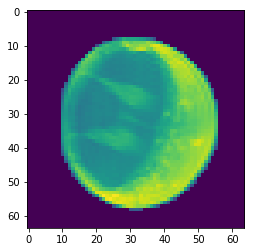

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(data_spinal_cord.signal[:,:,0,0])

## AxCaliber Without Gamma Distribution

In [5]:
cylinder = C4CylinderGaussianPhaseApproximation()
ball = G3Ball()

axcaliber = modeling_framework.MultiCompartmentModel(models=[ball, cylinder])
axcaliber.parameter_cardinality

OrderedDict([('G3Ball_1_lambda_iso', 1),
             ('C4CylinderGaussianPhaseApproximation_1_mu', 2),
             ('C4CylinderGaussianPhaseApproximation_1_lambda_par', 1),
             ('C4CylinderGaussianPhaseApproximation_1_diameter', 1),
             ('partial_volume_0', 1),
             ('partial_volume_1', 1)])

In [6]:
axcaliber.fix_parameter('C4CylinderGaussianPhaseApproximation_1_lambda_par', 1.7e-9)
axcaliber.fix_parameter('C4CylinderGaussianPhaseApproximation_1_mu', [0, 0])

In [7]:
axcaliber.parameter_cardinality

OrderedDict([('G3Ball_1_lambda_iso', 1),
             ('C4CylinderGaussianPhaseApproximation_1_diameter', 1),
             ('partial_volume_0', 1),
             ('partial_volume_1', 1)])

In [8]:
axcaliber_fit = axcaliber.fit(scheme_spinal_cord, data_spinal_cord.signal,
                              mask=data_spinal_cord.mask,
                              use_parallel_processing=True, Ns=10)

Using parallel processing with 8 workers.
Setup brute2fine optimizer in 1.7721619606 seconds
Fitting of 968 voxels complete in 11.013851881 seconds.
Average of 0.0113779461581 seconds per voxel.


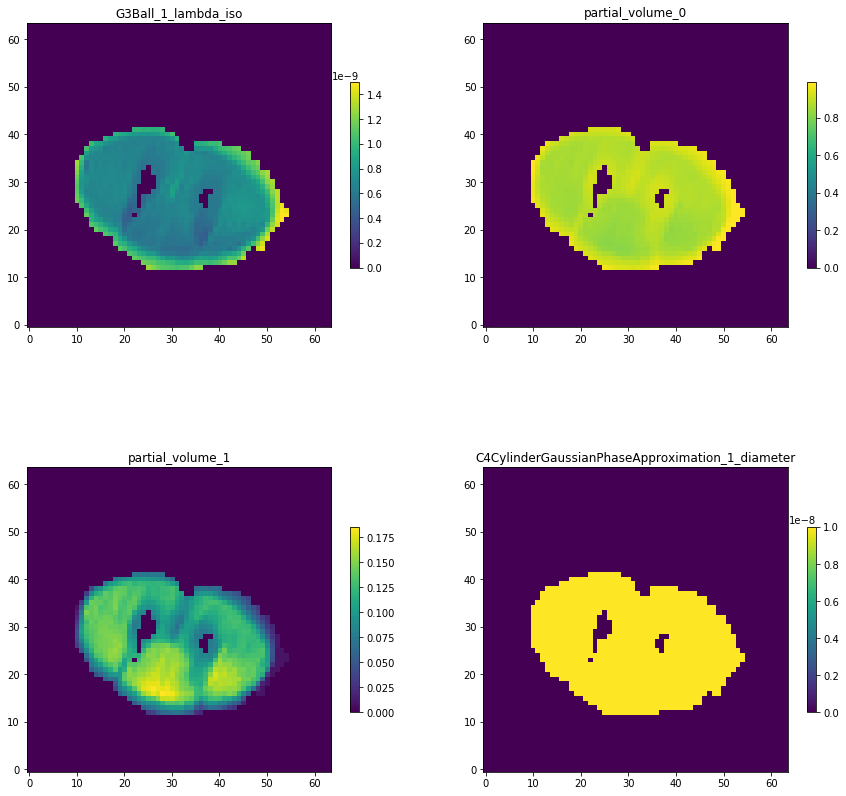

In [9]:
fitted_parameters = axcaliber_fit.fitted_parameters

fig, axs = plt.subplots(2, 2, figsize=[15, 15])
axs = axs.ravel()

counter = 0
for name, values in fitted_parameters.items():
    if values.squeeze().ndim != 2:
        continue
    cf = axs[counter].imshow(values.squeeze().T, origin=True, interpolation='nearest')
    axs[counter].set_title(name)
    fig.colorbar(cf, ax=axs[counter], shrink=0.5)
    counter += 1

## AxCaliber with Gamma Distribution

In [10]:
cylinder = C4CylinderGaussianPhaseApproximation()
ball = G3Ball()
gamma_cylinder = distribute_models.DD1GammaDistributed(models=[cylinder])

In [11]:
axcaliber_gamma = modeling_framework.MultiCompartmentModel(models=[ball, gamma_cylinder], parameter_links=[])
axcaliber_gamma.parameter_cardinality

OrderedDict([('G3Ball_1_lambda_iso', 1),
             ('DD1GammaDistributed_1_DD1GammaDistribution_1_beta', 1),
             ('DD1GammaDistributed_1_DD1GammaDistribution_1_alpha', 1),
             ('DD1GammaDistributed_1_C4CylinderGaussianPhaseApproximation_1_mu',
              2),
             ('DD1GammaDistributed_1_C4CylinderGaussianPhaseApproximation_1_lambda_par',
              1),
             ('partial_volume_0', 1),
             ('partial_volume_1', 1)])

In [12]:
axcaliber_gamma.fix_parameter(
    'DD1GammaDistributed_1_C4CylinderGaussianPhaseApproximation_1_lambda_par', 1.7e-9)
axcaliber_gamma.fix_parameter(
    'DD1GammaDistributed_1_C4CylinderGaussianPhaseApproximation_1_mu', [0, 0])

In [13]:
axcaliber_gamma.parameter_cardinality

OrderedDict([('G3Ball_1_lambda_iso', 1),
             ('DD1GammaDistributed_1_DD1GammaDistribution_1_beta', 1),
             ('DD1GammaDistributed_1_DD1GammaDistribution_1_alpha', 1),
             ('partial_volume_0', 1),
             ('partial_volume_1', 1)])

In [16]:
# takes about 2 hours with the Mix optimizer but the solution is better
axcaliber_gamma_fit = axcaliber_gamma.fit(
    scheme_spinal_cord, data_spinal_cord.signal,
    mask=data_spinal_cord.mask, solver='mix', maxiter=100)

Using parallel processing with 8 workers.
Setup MIX optimizer in 1.50203704834e-05 seconds
Fitting of 8 voxels complete in 78.9781630039 seconds.
Average of 9.87227037549 seconds per voxel.


In [ ]:
fitted_parameters = axcaliber_gamma_fit.fitted_parameters

fig, axs = plt.subplots(2, 3, figsize=[15, 15])
axs = axs.ravel()

counter = 0
for name, values in fitted_parameters.items():
    if values.squeeze().ndim != 2:
        continue
    cf = axs[counter].imshow(values.squeeze().T, origin=True, interpolation='nearest')
    axs[counter].set_title(name)
    fig.colorbar(cf, ax=axs[counter], shrink=0.5)
    counter += 1